In [45]:
from tqdm import tqdm
import torch
import numpy as np
import torch.nn as nn
from model import UNET
from settings import COLAB_PATH, NUM_EPOCHS,BATCH_SIZE,SPLIT_RATIO, LEARNING_RATE, device
from utils import get_data_loaders
from torchvision.utils import save_image
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from resizeImages import resize_with_pad
from torchvision import transforms
from PIL import Image
import os
import cv2
from typing import Tuple

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
def train():
    # TODO:  Do we need to feed the image size here ??
    model = UNET(in_channels=3, out_channels=10)
    model.to(device)
    print(summary(model, (3, 256, 256)) )

    for param in model.parameters():
        param.to(device)

    train_dl, val_dl, test_dl = get_data_loaders(COLAB_PATH, 16, SPLIT_RATIO)
    optimizer = torch.optim.Adam(model.parameters(), LEARNING_RATE)
    criterion = nn.functional.nll_loss
    writer = SummaryWriter()

    train_epoch_losses = []
    val_epoch_losses = []

    for epoch in range(20):
        model.train()

        running_loss = 0.0
        for images, masks in tqdm(train_dl, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS}"):
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()

            outputs = model(images)

            # # Extract predicted class indices
            # predicted_classes = torch.argmax(outputs[:, :, :, :], dim=1)
            # softmax_output = torch.nn.functional.softmax(predicted_classes.float(), dim=1)
            # # Extract ground truth class indices from the 4th channel of the mask
            # ground_truth_classes = masks[:, 3, :, :]

            loss = nn.functional.cross_entropy(outputs, masks)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        average_loss = running_loss / len(train_dl)
        train_epoch_losses.append(average_loss)
        writer.add_scalar("Loss/train", average_loss, epoch)

        # Validation loop
        model.eval()

        val_loss = 0.0
        with torch.no_grad():
            for images, masks in tqdm(val_dl, desc=f"Validation {epoch + 1}/{NUM_EPOCHS}"):
                images, masks = images.to(device), masks.to(device)

                outputs = model(images)

                loss = nn.functional.cross_entropy(outputs, masks)


                val_loss += loss.item()

        average_val_loss = val_loss / len(val_dl)
        val_epoch_losses.append(average_val_loss)
        writer.add_scalar("Loss/validation", average_val_loss, epoch)

        print(f"Epoch {epoch + 1}/{NUM_EPOCHS}, Loss: {average_loss:.4f}, Val Loss: {average_val_loss:.4f}")

    # Save the trained model
    torch.save(model.state_dict(), "unet_model_two.pth")


In [50]:
train()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,728
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,864
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
        DoubleConv-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
            Conv2d-9        [-1, 128, 128, 128]          73,728
      BatchNorm2d-10        [-1, 128, 128, 128]             256
             ReLU-11        [-1, 128, 128, 128]               0
           Conv2d-12        [-1, 128, 128, 128]         147,456
      BatchNorm2d-13        [-1, 128, 128, 128]             256
             ReLU-14        [-1, 128, 1

Validation 1/3: 100%|██████████| 8/8 [00:03<00:00,  2.36it/s]


Epoch 1/3, Loss: 1.2856, Val Loss: 1.0002


Validation 2/3: 100%|██████████| 8/8 [00:03<00:00,  2.46it/s]


Epoch 2/3, Loss: 0.5842, Val Loss: 0.5720


Validation 3/3: 100%|██████████| 8/8 [00:03<00:00,  2.47it/s]


Epoch 3/3, Loss: 0.5073, Val Loss: 0.5111


Validation 4/3: 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


Epoch 4/3, Loss: 0.4840, Val Loss: 0.4953


Validation 5/3: 100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Epoch 5/3, Loss: 0.4753, Val Loss: 0.4838


Validation 6/3: 100%|██████████| 8/8 [00:03<00:00,  2.46it/s]


Epoch 6/3, Loss: 0.4694, Val Loss: 0.4858


Validation 7/3: 100%|██████████| 8/8 [00:03<00:00,  2.42it/s]


Epoch 7/3, Loss: 0.4675, Val Loss: 0.4979


Validation 8/3: 100%|██████████| 8/8 [00:03<00:00,  2.44it/s]


Epoch 8/3, Loss: 0.4611, Val Loss: 0.4723


Validation 9/3: 100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


Epoch 9/3, Loss: 0.4575, Val Loss: 0.4726


Validation 10/3: 100%|██████████| 8/8 [00:03<00:00,  2.23it/s]


Epoch 10/3, Loss: 0.4560, Val Loss: 0.4682


Validation 11/3: 100%|██████████| 8/8 [00:03<00:00,  2.40it/s]


Epoch 11/3, Loss: 0.4565, Val Loss: 0.4966


Validation 12/3: 100%|██████████| 8/8 [00:03<00:00,  2.46it/s]


Epoch 12/3, Loss: 0.4522, Val Loss: 0.4611


Validation 13/3: 100%|██████████| 8/8 [00:03<00:00,  2.44it/s]


Epoch 13/3, Loss: 0.4517, Val Loss: 0.5227


Validation 14/3: 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


Epoch 14/3, Loss: 0.4529, Val Loss: 0.5846


Validation 15/3: 100%|██████████| 8/8 [00:03<00:00,  2.30it/s]


Epoch 15/3, Loss: 0.4485, Val Loss: 0.4712


Validation 16/3: 100%|██████████| 8/8 [00:03<00:00,  2.46it/s]


Epoch 16/3, Loss: 0.4479, Val Loss: 0.4638


Validation 17/3: 100%|██████████| 8/8 [00:03<00:00,  2.46it/s]


Epoch 17/3, Loss: 0.4468, Val Loss: 0.4636


Validation 18/3: 100%|██████████| 8/8 [00:03<00:00,  2.46it/s]


Epoch 18/3, Loss: 0.4451, Val Loss: 0.4795


Validation 19/3: 100%|██████████| 8/8 [00:03<00:00,  2.21it/s]


Epoch 19/3, Loss: 0.4479, Val Loss: 0.5916


Validation 20/3: 100%|██████████| 8/8 [00:03<00:00,  2.46it/s]


Epoch 20/3, Loss: 0.4466, Val Loss: 0.6630


### Load the trained model

In [51]:
mdl = UNET(in_channels=3, out_channels=10)
mdl.load_state_dict(torch.load('/content/unet_model_two.pth'))

<All keys matched successfully>

### Resize function to be used for test images

In [52]:
def resize_with_pad(image: np.array,
                    new_shape: Tuple[int, int],
                    padding_color: Tuple[int] = (0,0,0)) -> np.array:
    """Maintains aspect ratio and resizes with padding.
    Params:
        image: Image to be resized.
        new_shape: Expected (width, height) of new image.
        padding_color: Tuple in BGR of padding color
    Returns:
        image: Resized image with padding
    """
    original_shape = (image.shape[1], image.shape[0])
    ratio = float(max(new_shape))/max(original_shape)
    new_size = tuple([int(x*ratio) for x in original_shape])
    image = cv2.resize(image, new_size)
    delta_w = new_shape[0] - new_size[0]
    delta_h = new_shape[1] - new_size[1]
    top, bottom = 0, delta_h
    left, right = delta_w//2, delta_w-(delta_w//2)
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=padding_color)
    return image

### TEST LOOP

In [57]:
test_folder_path = '/content/drive/MyDrive/data/carseg_data/images/photo/no_segmentation'  # Replace with the actual path

# Create a list to store the model outputs
model_outputs = []
model_outputs_images = []

# Set the model to evaluation mode
mdl.eval()

# Define the transformation to be applied to the input images
transform = transforms.Compose([transforms.ToTensor()])
index = 0

# Iterate through the images in the test folder
for filename in os.listdir(test_folder_path):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # Load the image
        image_path = os.path.join(test_folder_path, filename)
        img = cv2.imread(image_path)
        resized = resize_with_pad(img, (256, 256))

        # Apply the specified transformations
        input_image = transform(resized).unsqueeze(0)  # Add batch dimension

        # Make the prediction
        with torch.no_grad():
            output = mdl(input_image)

        # Store the output in the list
        model_outputs.append(output)
        model_outputs_images.append(img)

        #detect for first 10 images
        if index == 10:
          break
        index = index + 1
        print(index)

# The `model_outputs` list now contains the model's output for each test image

1
2
3
4
5
6
7
8
9
10


In [60]:
# Should be size 1, 10, 256, 256 for 1 image with 10 classes with 256x256 size
print(model_outputs[0].shape)
output = []
for out in model_outputs:
  print(out.argmax(dim=1).unique())
  output.append(out.argmax(dim=1))

torch.Size([1, 10, 256, 256])
tensor([0, 9])
tensor([0, 9])
tensor([0])
tensor([0, 9])
tensor([0, 9])
tensor([0, 9])
tensor([0, 9])
tensor([0, 9])
tensor([0])
tensor([0, 9])
tensor([0, 9])


### COLORFUL SEGMENTATION PLOT

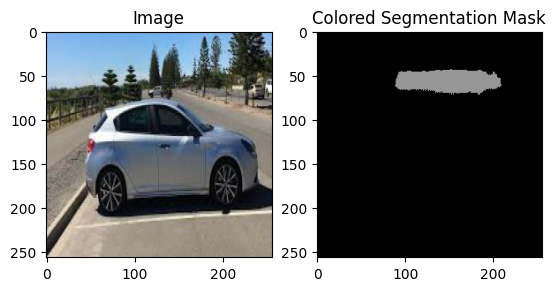

In [61]:
import matplotlib.pyplot as plt

def colorize_segmentation_mask(segmentation_tensor):
    # Define color mapping for each class
    color_mapping = {
        0: (0,0,0),
        1: (250, 149, 10),
        2: (19, 98, 19),
        3: (249, 249, 10),
        4: (10, 248, 250),
        5: (149, 7, 149),
        6: (5, 249, 9),
        7: (20, 19, 249),
        8: (249, 9, 250),
        9: (150, 150, 150),
    }

    # Convert the PyTorch tensor to a NumPy array
    segmentation_array = segmentation_tensor.squeeze(0).cpu().numpy()

    # Create a mapping from actual class values to color values
    class_to_color = {class_value: color_mapping[class_value] for class_value in np.unique(segmentation_array)}

    # Create an RGB image with the colored segmentation mask
    colored_mask = np.zeros((256, 256, 3), dtype=np.uint8)
    for class_value, color in class_to_color.items():
        colored_mask[segmentation_array == class_value] = color

    return colored_mask

image_index_to_display = 3
# Example usage:
# Assuming `model_outputs` is a list containing tensors with shapes [1, 10, 256, 256]
segmentation_tensor = output[image_index_to_display]  # Assuming we're using the output of the first image

plt.subplot(1, 2, 2)
colored_mask = colorize_segmentation_mask(segmentation_tensor)
plt.imshow(colored_mask)
plt.title('Colored Segmentation Mask')

plt.subplot(1, 2, 1)
img_rgb = cv2.cvtColor(model_outputs_images[image_index_to_display], cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.title('Image')


# ## I USED THIS JUST TO CHECK IF PLOTTING WORKS AS A SANITH CHECK
# tensor_of_fives = torch.full((1, 10, 256, 256), 0, dtype=torch.float32)
# tensor_of_fives[0, 1, :, :] = 5
# tensor_test = tensor_of_fives.argmax(dim=1)
# plt.subplot(1, 2, 2)
# colored_mask = colorize_segmentation_mask(tensor_test)
# plt.imshow(colored_mask)
# plt.title('Colored Segmentation Mask')

plt.show()